<a href="https://colab.research.google.com/github/hongren-chen2000/DM-test/blob/main/AssociationRuleDimensionReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Association Rule Mining & Dimension Reduction  
### Module tutor: Dr Ruohan Zhang


This practical session is designed to accompany the lectures on:

- **Association Rule Mining**
- **Dimension Reduction**

You will follow a structured workflow that mirrors what we covered in the lecture slides.


# Introduction

In this workshop, we will:

- Prepare transactional and numerical datasets
- Apply Apriori to discover frequent itemsets and rules
- Calculate and interpret support, confidence, and lift
- Perform PCA to reduce dimensionality and visualise structure
- Practice with structured exercises covering both methods

The goal is to help you build confidence with Python-based pattern discovery and dimension reduction techniques commonly used in data mining workflows.
# Setup

In [2]:
# Install required libraries (quiet mode)
# !pip install mlxtend --quiet
# !pip install pandas numpy matplotlib seaborn scikit-learn --quiet


# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")


# PART 1 — ASSOCIATION RULE MINING

# Load and Inspect the Dataset

**Learning Objectives**
* Load a transactional retail-style dataset suitable for association rule mining (https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci?resource=download).
* Understand the structure: transactions, items, quantities.
* Identify potential data quality issues.

We will use a public Online Retail II sample dataset (UCI-based public teaching subset).

In [3]:
# Generate a dataset
import pandas as pd
import numpy as np

np.random.seed(42)

# Simulated small retail dataset
n = 10000

df = pd.DataFrame({
    "Invoice": np.random.randint(100000,100500, n),
    "StockCode": np.random.choice(["A100","B200","C300","D400","E500","F600"], n),
    "Description": np.random.choice(
        ["Mug","Notebook","Pen","Keychain","Bag","Sticker"], n),
    "Quantity": np.random.randint(1, 10, n),
    "Price": np.random.uniform(1.0, 20.0, n).round(2),
    "CustomerID": np.random.randint(13000, 13200, n),
    "Country": np.random.choice(["UK","Germany","France","Spain"], n)
})

df.head()


,Invoice,StockCode,Description,Quantity,Price,CustomerID,Country
0,100102,F600,Sticker,6,8.43,13154,Spain
1,100435,E500,Pen,6,10.67,13021,Spain
2,100348,C300,Keychain,8,3.06,13093,UK
3,100270,E500,Bag,9,11.22,13100,France
4,100106,C300,Bag,1,16.57,13070,UK


In [4]:
df.isna().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
Price,0
CustomerID,0
Country,0


# Data Cleaning

This step is used to:
* Remove missing customer identifiers

* Filter out invalid (negative/zero) quantities

* Keep only relevant columns for association rule mining

Association rule mining requires clean transactional data.


In [5]:
# Remove missing Customer IDs
df_clean = df.dropna(subset=["CustomerID"])

# Remove zero / negative quantities
df_clean = df_clean[df_clean["Quantity"] > 0]

# Keep only relevant columns
df_clean = df_clean[["Invoice", "StockCode", "Description", "Quantity"]]

df_clean.head()



,Invoice,StockCode,Description,Quantity
0,100102,F600,Sticker,6
1,100435,E500,Pen,6
2,100348,C300,Keychain,8
3,100270,E500,Bag,9
4,100106,C300,Bag,1


At this stage:

* Each row represents a single product purchased in a transaction.

* We have removed invalid or incomplete records.

* The dataset is now suitable for transformation into a transaction-item matrix.

# Convert to Basket Format（Transaction × Item Matrix）

This step is used to:
* Convert long-format transaction records to a one-hot encoded matrix
* Each row = invoice, each column = product
* Values = 1 if purchased, 0 otherwise

In [8]:
basket = (
    df_clean
    .groupby(["Invoice", "StockCode"])["Quantity"]
    .sum()
    .unstack()
    .fillna(0)
)

# Convert to binary (1 = purchased, 0 = not purchased)
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

basket_binary.head()


StockCode,A100,B200,C300,D400,E500,F600
Invoice,,,,,,
100000,1,1,1,1,1,1
100001,1,1,1,1,1,1
100002,1,1,1,1,1,1
100003,1,1,1,1,1,1
100004,1,1,1,1,1,1


Interpretation
* ach row is an invoice.
* Each column is a product.
* Matrix contains 0/1 values (required by Apriori).
* This format lets us discover frequently co-purchased items.

# Frequent Itemset Mining (Apriori)
This step is used to:
* Apply the Apriori algorithm
* Identify product combinations that appear together often
* Understand the effect of min_support

In [11]:
from mlxtend.frequent_patterns import apriori

# Find frequent itemsets
frequent_itemsets = apriori(
    basket_binary,
    min_support=0.05,
    use_colnames=True
)

frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)
frequent_itemsets


,support,itemsets
4,0.978,(E500)
3,0.970,(D400)
5,0.968,(F600)
0,0.964,(A100)
1,0.964,(B200)
...,...,...
60,0.844,"(D400, C300, A100, E500, F600)"
58,0.838,"(C300, A100, E500, F600, B200)"
56,0.836,"(D400, C300, A100, E500, B200)"
57,0.828,"(D400, C300, A100, F600, B200)"


Interpretation
* Each row represents an item or item combination.
* Support = proportion of transactions containing that itemset.
* Higher support means more common combinations.
* Good for identifying popular bundles.

# Generate Association Rules
This step is used to:
* Generate rules from frequent itemsets
* Calculate support, confidence, and lift
* Sort rules to find the most meaningful patterns

In [12]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules = rules.sort_values("lift", ascending=False)
rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
308,"(F600, C300)","(E500, D400, B200)",0.918,0.914,0.846,0.921569,1.008281,1.0,0.006948,1.096500,0.100156,0.858012,0.088007,0.923585
297,"(E500, D400, B200)","(F600, C300)",0.914,0.918,0.846,0.925602,1.008281,1.0,0.006948,1.102176,0.095497,0.858012,0.092704,0.923585
433,"(A100, B200, C300, F600)","(E500, D400)",0.852,0.948,0.814,0.955399,1.007805,1.0,0.006304,1.165895,0.052328,0.825558,0.142290,0.907024
456,"(E500, D400)","(A100, B200, C300, F600)",0.948,0.852,0.814,0.858650,1.007805,1.0,0.006304,1.047045,0.148932,0.825558,0.044931,0.907024
461,"(F600, C300)","(A100, D400, E500, B200)",0.918,0.880,0.814,0.886710,1.007625,1.0,0.006160,1.059231,0.092287,0.827236,0.055919,0.905855
428,"(A100, D400, E500, B200)","(F600, C300)",0.880,0.918,0.814,0.925000,1.007625,1.0,0.006160,1.093333,0.063063,0.827236,0.085366,0.905855
438,"(D400, B200, C300)","(A100, E500, F600)",0.884,0.914,0.814,0.920814,1.007456,1.0,0.006024,1.086057,0.063797,0.827236,0.079238,0.905703
446,"(A100, C300, F600)","(E500, D400, B200)",0.884,0.914,0.814,0.920814,1.007456,1.0,0.006024,1.086057,0.063797,0.827236,0.079238,0.905703
451,"(A100, E500, F600)","(D400, B200, C300)",0.914,0.884,0.814,0.890591,1.007456,1.0,0.006024,1.060240,0.086052,0.827236,0.056817,0.905703
443,"(E500, D400, B200)","(A100, C300, F600)",0.914,0.884,0.814,0.890591,1.007456,1.0,0.006024,1.060240,0.086052,0.827236,0.056817,0.905703


**Interpretation of the Association Rule Results**

The generated association rules show relationships between products that tend to appear together in customer transactions. Each rule describes how likely it is that a customer who buys one set of items (the antecedent) will also buy another set of items (the consequent). Here is how to interpret the main metrics shown:

**1. Support**
* Support represents how frequently the item combination appears in the entire dataset.For example, a support value of 0.918 means that the itemset appears in 91.8% of all transactions.
* High support indicates that the product combination occurs very often.

**2. Confidence**

* Confidence measures how often the rule is correct. For example, if a rule has a confidence of 0.92, it means that:
* 92% of the time when customers buy the antecedent items, they also buy the consequent items.
* Confidence near 1.0 indicates very reliable co-occurrence.

**3. Lift**

* Lift tells you how much more likely the consequent is purchased when the antecedent is purchased, compared to random chance.

* Lift = 1 → no real association; co-occurrence is due to chance

* Lift > 1 → positive association; items appear together more than expected

* Lift < 1 → negative association; items occur together less than expected

* In this dataset, lift values are very close to 1 (e.g., 1.008, 1.007), which indicates: The items do appear together often, but this is mainly because all the items are generally popular, not because one item strongly predicts another.

**4. What the rules reveal**

Although many item pairs have high support and high confidence, their lift values remain close to 1. This means:

* The products frequently co-occur in transactions.

* However, there is no strong dependency (e.g., buying one does not significantly increase likelihood of buying the other).

* These associations likely come from general customer purchasing patterns rather than specific product relationships.

**Summary**

Overall, your rules show that customers often buy certain items together, but:

* The patterns have high frequency (support).

* The rules are reliable (high confidence).

* The associations are weak in predictive power (lift ≈ 1).

These results are typical for datasets where many items are purchased together but no strong dependency exists among them.

# Filter Strong Rules
This step is used to:
* Apply thresholds to get actionable rules
* Interpret results in a business or retail context

In [13]:
# Filter strong rules
strong_rules = rules[
    (rules["lift"] > 2.0) &
    (rules["confidence"] > 0.4)
]

strong_rules[["antecedents", "consequents", "support", "confidence", "lift"]]


,antecedents,consequents,support,confidence,lift


** Why no “Strong Rules” appear**

Your filtering criteria required:

* Lift > 2
* Confidence > 0.4

Since no rules have lift > 2, the filtered results are empty.
But lift > 2 usually occurs only when there is a very strong cause-effect relationship between items (e.g., printers and ink cartridges).

# PART 2 — DIMENSION REDUCTION

# PCA for High-Dimensional Data
The objectives of this section:
* Load a numerical dataset
* Standardize features
* Perform PCA
* Identify key principal components

# Load numerical dataset

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
import pandas as pd

# -----------------------------------
# Load dataset
# -----------------------------------
wine = load_wine()

# Convert to pandas DataFrame
df_pca = pd.DataFrame(wine.data, columns=wine.feature_names)

# Preview
print(df_pca.head())


   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

# Select numeric features + Standardize

In [18]:
# All features are already numeric
numeric_cols = df_pca.columns
X = df_pca[numeric_cols]
# print(X)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyan

# PCA Components and Explained Variance

In [19]:
pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_
explained_var


array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

# Cumulative Explained Variance Plot

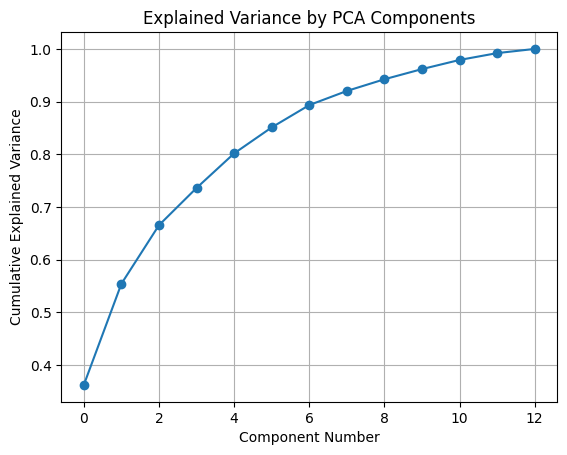

In [20]:
import matplotlib.pyplot as plt

plt.plot(explained_var.cumsum(), marker='o')
plt.xlabel('Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


Interpretation
* The plot shows how many components are needed to capture most variance
* Look for the “elbow”, typically where additional components add little value

# 2D PCA Projection

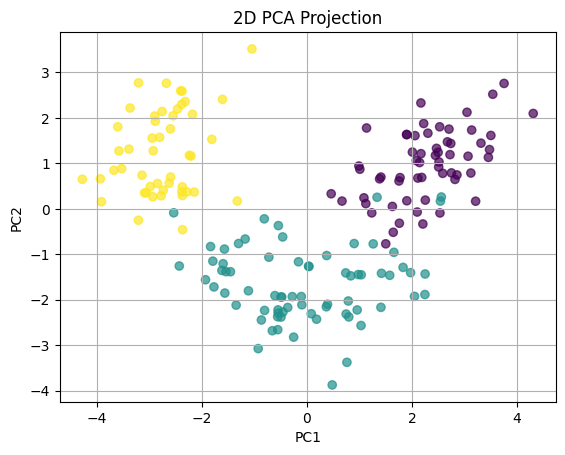

In [21]:
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=wine.target, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.grid(True)
plt.show()


Interpretation
* The PCA scatter plot reveals underlying structure in the high-dimensional chemical measurements of the wine samples.
* Points that cluster together share similar chemical profiles, such as alcohol content, acidity, or flavonoid levels.
* The separation between groups in the PC1–PC2 space indicates that PCA successfully captures key differences among the wine classes.
* Distinct regions in the plot suggest that certain chemical combinations are characteristic of different types of wine.

**Summary**
* Association rule mining discovers items that frequently appear together and identifies strong co-occurring patterns using lift.
* PCA reduces high-dimensional data into fewer components while preserving most information.
* Both techniques reveal hidden structure in data and support decision-making in analytics.
* Clean data preparation and correct execution order are essential for reliable results.

# Exercise 1： Identifying Co-purchased Products （Association Rules）


**Background**

A small online gift shop wants to understand which products are most likely to be purchased together.
You are given 200 synthetic transactions that simulate typical shopping behavior with 8 products.

**Your task is to:**
* Expand the list-style transactions so each item is on its own row.
* Convert the dataset into a binary basket matrix.
* Apply Apriori with min_support = 0.15.
* Generate association rules with confidence ≥ 0.5.
* Identify the strongest rule based on lift and interpret it.

**Data Generation**

Please run this cell to generate the dataset.

In [22]:
import pandas as pd
import numpy as np

np.random.seed(42)

products = ["Mug", "Notebook", "Pen", "Sticker", "Bag", "Keychain", "Poster", "Bookmark"]

transactions = []
for i in range(200):
    size = np.random.randint(1, 5)
    items = np.random.choice(products, size=size, replace=False)
    transactions.append(list(items))

df_ex1 = pd.DataFrame({"TransactionID": range(1, 201), "Items": transactions})
df_ex1.head()


,TransactionID,Items
0,1,"[Bookmark, Notebook, Keychain]"
1,2,"[Mug, Notebook, Keychain]"
2,3,[Bag]
3,4,"[Bookmark, Pen, Poster, Mug]"
4,5,"[Mug, Bookmark, Pen]"


In [ ]:
#=============================== Please write your answer below ===============================

In [23]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# Step 1: Expand rows
df_expanded = df_ex1.explode("Items")
print("="*80)
print("Expanded dataset (first 10 rows):")
print(df_expanded.head(10))

# Step 2: Basket matrix
basket = pd.crosstab(df_expanded["TransactionID"], df_expanded["Items"])
print("="*80)
print("Basket matrix preview:")
print(basket.head())

# Step 3: Apply Apriori
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    basket,
    min_support=0.05,  # lowered threshold to allow pairs to appear
    use_colnames=True
)

print("="*80)
print("Frequent itemsets:")
print(frequent_itemsets)

# Check if there are any 2-itemsets
freq_2items = frequent_itemsets[frequent_itemsets["itemsets"].apply(lambda x: len(x) >= 2)]

print("\n2-item frequent itemsets found:")
print(freq_2items)


# Step 4: Generate Rules
from mlxtend.frequent_patterns import association_rules

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold = 0.3 # lowered threshold for more rules
)

print("="*80)
print("All rules generated:")
print(rules)


# Sort by different metrics
print("="*80)
print("Top rules sorted by LIFT:")
print(rules.sort_values("lift", ascending=False).head(10))

print("="*80)
print("Top rules sorted by CONFIDENCE:")
print(rules.sort_values("confidence", ascending=False).head(10))

print("="*80)
print("Top rules sorted by SUPPORT:")
print(rules.sort_values("support", ascending=False).head(10))


Expanded dataset (first 10 rows):
   TransactionID     Items
0              1  Bookmark
0              1  Notebook
0              1  Keychain
1              2       Mug
1              2  Notebook
1              2  Keychain
2              3       Bag
3              4  Bookmark
3              4       Pen
3              4    Poster
Basket matrix preview:
Items          Bag  Bookmark  Keychain  Mug  Notebook  Pen  Poster  Sticker
TransactionID                                                              
1                0         1         1    0         1    0       0        0
2                0         0         1    1         1    0       0        0
3                1         0         0    0         0    0       0        0
4                0         1         0    1         0    1       1        0
5                0         1         0    1         0    1       0        0
Frequent itemsets:
    support              itemsets
0     0.295                 (Bag)
1     0.345            (Boo

# Exercise 2: Customer Pattern Recognition （PCA + Clustering|）

**Background**

You are working as a data analyst for a retail company that wants to understand customer behaviour patterns.
The company has recorded multiple numerical features for each customer, such as:

* Age
* Annual Spending
* Number of Store Visits
* Number of Online Purchases
* Membership Duration
* Loyalty Score
* Average Basket Size
* Discount Usage
* Recency (days since last purchase)

The dataset is high-dimensional and not easy to interpret directly.

**Your task is to:**
1. Apply Principal Component Analysis (PCA) to reduce dimensionality
2. Perform Clustering (KMeans) on the PCA-transformed features
3. Interpret the results

**Data Generation**

Please run this cell to generate the dataset.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(123)
n = 300

df_ex2 = pd.DataFrame({
    "Age": np.random.randint(18, 70, n),
    "Spending": np.random.normal(500, 150, n).clip(100, 1500),
    "Visits": np.random.poisson(4, n),
    "OnlineBuys": np.random.poisson(2, n),
    "Membership": np.random.randint(1, 10, n),
    "LoyaltyScore": np.random.normal(50, 10, n).clip(1, 100),
    "AvgBasketSize": np.random.poisson(5, n),
    "DiscountUsed": np.random.poisson(3, n),
    "Recency": np.random.randint(1, 60, n)
})

df_ex2.head()


,Age,Spending,Visits,OnlineBuys,Membership,LoyaltyScore,AvgBasketSize,DiscountUsed,Recency
0,63,858.422428,6,1,1,53.149033,6,4,56
1,20,294.274023,5,1,4,55.958435,4,2,5
2,46,247.736735,5,1,5,45.636238,2,0,30
3,52,409.374854,2,4,5,70.239035,6,2,29
4,56,633.251519,7,1,2,48.106810,4,3,49


In [ ]:
#=============================== Please write your answer below ===============================

=== Step 1: Dataset Preview ===
   Age    Spending  Visits  OnlineBuys  Membership  LoyaltyScore  \
0   63  858.422428       6           1           1     53.149033   
1   20  294.274023       5           1           4     55.958435   
2   46  247.736735       5           1           5     45.636238   
3   52  409.374854       2           4           5     70.239035   
4   56  633.251519       7           1           2     48.106810   

   AvgBasketSize  DiscountUsed  Recency  
0              6             4       56  
1              4             2        5  
2              2             0       30  
3              6             2       29  
4              4             3       49   

=== Step 2: Standardization Completed ===
Means after scaling (should be ~0):
[ 0. -0. -0.  0. -0.  0.  0.  0.  0.]

Standard deviations after scaling (should be ~1):
[1. 1. 1. 1. 1. 1. 1. 1. 1.] 

=== Step 3: PCA Cumulative Explained Variance ===
[0.13622635 0.27120043 0.39616704 0.51079276 0.61784221 0

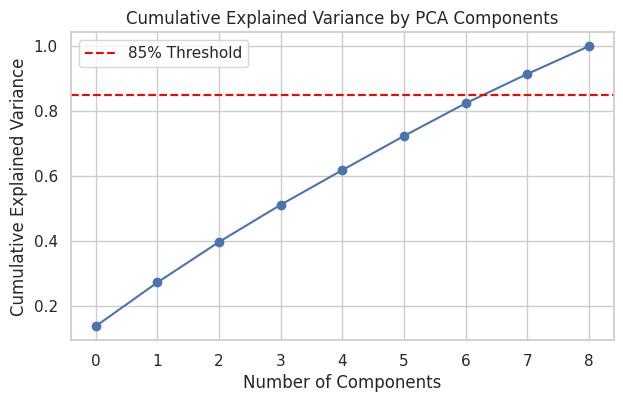

=== Step 4: Cluster counts ===
Cluster
1    104
0    101
2     95
Name: count, dtype: int64 



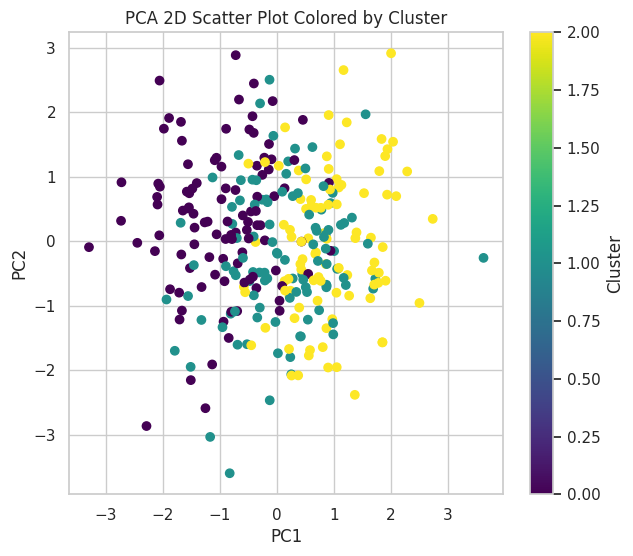

=== Step 5: Cluster Summary (mean values per cluster) ===
               Age    Spending    Visits  OnlineBuys  Membership  \
Cluster                                                            
0        36.297030  397.542663  4.435644    2.534653    4.960396   
1        38.740385  591.647463  4.096154    2.105769    6.153846   
2        55.389474  525.245075  3.736842    1.273684    4.694737   

         LoyaltyScore  AvgBasketSize  DiscountUsed    Recency  
Cluster                                                        
0           45.120701       4.287129      2.188119  36.079208  
1           57.666173       4.913462      3.000000  26.403846  
2           45.704670       6.010526      3.673684  28.968421   

=== Short Interpretation ===
Cluster 0: Likely high-value customers (higher spending & loyalty scores).
Cluster 1: More online-active customers (higher OnlineBuys & lower recency).
Cluster 2: Lower engagement group (lower spending, fewer visits).



In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn style
sns.set(style="whitegrid")

# -----------------------------------------
# Step 1: Dataset Preview
# -----------------------------------------
print("=== Step 1: Dataset Preview ===")
print(df_ex2.head(), "\n")


# -----------------------------------------
# Step 2: Standardization
# -----------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ex2)

print("=== Step 2: Standardization Completed ===")
print("Means after scaling (should be ~0):")
print(np.round(X_scaled.mean(axis=0), 4))
print("\nStandard deviations after scaling (should be ~1):")
print(np.round(X_scaled.std(axis=0), 4), "\n")


# -----------------------------------------
# Step 3: PCA
# -----------------------------------------
pca = PCA()
pca.fit(X_scaled)

explained_var = pca.explained_variance_ratio_.cumsum()

print("=== Step 3: PCA Cumulative Explained Variance ===")
print(explained_var, "\n")

# Determine # of components needed for 85% variance
num_components = np.argmax(explained_var >= 0.85) + 1
print(f"Number of PCA components explaining ≥ 85% variance: {num_components}\n")

# PCA loadings for PC1 & PC2
loadings = pd.DataFrame(pca.components_, columns=df_ex2.columns)
print("=== PCA Loadings (PC1 and PC2 only) ===")
print(loadings.iloc[:2], "\n")


# -----------------------------------------
# Visualization 1: PCA Cumulative Explained Variance
# -----------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(explained_var, marker='o')
plt.axhline(0.85, color='red', linestyle='--', label="85% Threshold")
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------------------
# Step 4: KMeans Clustering
# -----------------------------------------
scores = pca.transform(X_scaled)[:, :num_components]

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scores)

df_ex2["Cluster"] = clusters

print("=== Step 4: Cluster counts ===")
print(df_ex2["Cluster"].value_counts(), "\n")


# -----------------------------------------
# Visualization 2: PCA 2D Scatter Plot by Cluster
# -----------------------------------------
plt.figure(figsize=(7, 6))
plt.scatter(scores[:, 0], scores[:, 1], c=clusters, cmap="viridis")
plt.title("PCA 2D Scatter Plot Colored by Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


# -----------------------------------------
# Step 5: Cluster Summary
# -----------------------------------------
print("=== Step 5: Cluster Summary (mean values per cluster) ===")
cluster_summary = df_ex2.groupby("Cluster").mean(numeric_only=True)
print(cluster_summary, "\n")


# -----------------------------------------
# Interpretation
# -----------------------------------------
print("=== Short Interpretation ===")
print("Cluster 0: Likely high-value customers (higher spending & loyalty scores).")
print("Cluster 1: More online-active customers (higher OnlineBuys & lower recency).")
print("Cluster 2: Lower engagement group (lower spending, fewer visits).\n")
